In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchsummary import summary
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_curve, auc, average_precision_score, precision_recall_curve
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tabulate import tabulate

In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Set paths for dataset splits
train_dir = 'I:/RICE/final_rice_data/train'
val_dir = 'I:/RICE/final_rice_data/val'
test_dir = 'I:/RICE/final_rice_data/test'

In [4]:
# Function to count images in a directory
def count_images_in_directory(directory):
    count = 0
    for _, _, files in os.walk(directory):
        count += len([f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    return count

# Count images in each directory
train_count = count_images_in_directory(train_dir)
val_count = count_images_in_directory(val_dir)
test_count = count_images_in_directory(test_dir)

# Display the counts
print(f"Total number of images in the training set: {train_count}")
print(f"Total number of images in the validation set: {val_count}")
print(f"Total number of images in the test set: {test_count}")

Total number of images in the training set: 10000
Total number of images in the validation set: 1250
Total number of images in the test set: 1250


In [5]:
# Data augmentation and normalization for training
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),          # Resize images
    transforms.RandomHorizontalFlip(),        # Random horizontal flip
    transforms.RandomRotation(20),            # Random rotation
    transforms.ToTensor(),                    # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize
])


In [6]:
# Normalization for validation and test
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [7]:
# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_test_transforms)
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transforms)

In [8]:
# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
# Define the EfficientNet-B7 model architecture
class EfficientNetB7Model(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetB7Model, self).__init__()
        self.efficientnet_b7 = models.efficientnet_b7(pretrained=True)  # Load EfficientNet-B7 with pretrained weights
        self.efficientnet_b7.classifier[1] = nn.Linear(2560, num_classes)  # Modify the last layer to match the number of classes

    def forward(self, x):
        return self.efficientnet_b7(x)

num_classes = 5  # Number of classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNetB7Model(num_classes).to(device)

C:\Users\Administrator\anaconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Administrator\anaconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# Display model summary
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           1,728
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              SiLU-3         [-1, 64, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]             576
       BatchNorm2d-5         [-1, 64, 112, 112]             128
              SiLU-6         [-1, 64, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 64, 1, 1]               0
            Conv2d-8             [-1, 16, 1, 1]           1,040
              SiLU-9             [-1, 16, 1, 1]               0
           Conv2d-10             [-1, 64, 1, 1]           1,088
          Sigmoid-11             [-1, 64, 1, 1]               0
SqueezeExcitation-12         [-1, 64, 112, 112]               0
           Conv2d-13         [-1, 32, 112, 112]           2,048
      BatchNorm2d-14         [-1, 32, 1

In [11]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [12]:
# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader, desc='Training', leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

In [13]:
# Validation function
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    accuracy = 100 * correct / total
    return avg_val_loss, accuracy

In [14]:
# Define a function to train and validate the model with early stopping
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, patience=5):
    # Store losses and accuracies
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    best_val_accuracy = 0
    epochs_without_improvement = 0
    
    for epoch in range(num_epochs):
        # Train the model
        train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
        # Validate the model
        val_loss, val_accuracy = validate(model, val_loader, criterion, device)

        # Append to lists for plotting later
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print training and validation results
        print(f"Epoch {epoch + 1}/{num_epochs} - "
              f"Training Accuracy: {train_accuracy:.4f} - "
              f"Training Loss: {train_loss:.4f} - "
              f"Validation Accuracy: {val_accuracy:.4f} - "
              f"Validation Loss: {val_loss:.4f}")

        # Check if we have a new best validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            epochs_without_improvement = 0
            # Save the best model state
            torch.save(model.state_dict(), 'best_crack_detection_model.pth')
            print(f"Best model saved with accuracy: {best_val_accuracy:.4f}%")
        else:
            epochs_without_improvement += 1
        
        # Check for early stopping
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered. Stopping training at epoch {epoch + 1}.")
            break

    return train_losses, val_losses, val_accuracies

In [15]:
# Train and evaluate the model
num_epochs = 30
train_losses, val_losses, val_accuracies = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

Epoch 1/30 - Training Accuracy: 64.7000 - Training Loss: 1.0036 - Validation Accuracy: 21.2800 - Validation Loss: 1.6398
Best model saved with accuracy: 21.2800%


Epoch 2/30 - Training Accuracy: 89.1700 - Training Loss: 0.3352 - Validation Accuracy: 66.0000 - Validation Loss: 0.9318
Best model saved with accuracy: 66.0000%


Epoch 3/30 - Training Accuracy: 93.2600 - Training Loss: 0.1990 - Validation Accuracy: 63.1200 - Validation Loss: 1.2042


Epoch 4/30 - Training Accuracy: 94.6200 - Training Loss: 0.1546 - Validation Accuracy: 87.9200 - Validation Loss: 0.3481
Best model saved with accuracy: 87.9200%


Epoch 5/30 - Training Accuracy: 95.7400 - Training Loss: 0.1262 - Validation Accuracy: 89.0400 - Validation Loss: 0.3210
Best model saved with accuracy: 89.0400%


Epoch 6/30 - Training Accuracy: 96.0700 - Training Loss: 0.1113 - Validation Accuracy: 86.1600 - Validation Loss: 0.3187


Epoch 7/30 - Training Accuracy: 96.9400 - Training Loss: 0.0989 - Validation Accuracy: 98.4800 - Validation Loss: 0.0522
Best model saved with accuracy: 98.4800%


Epoch 8/30 - Training Accuracy: 97.0500 - Training Loss: 0.0878 - Validation Accuracy: 79.2800 - Validation Loss: 0.5844


Epoch 9/30 - Training Accuracy: 97.5500 - Training Loss: 0.0747 - Validation Accuracy: 88.3200 - Validation Loss: 0.3255


Epoch 10/30 - Training Accuracy: 97.5900 - Training Loss: 0.0761 - Validation Accuracy: 98.8800 - Validation Loss: 0.0334
Best model saved with accuracy: 98.8800%


Epoch 11/30 - Training Accuracy: 97.9700 - Training Loss: 0.0604 - Validation Accuracy: 98.8000 - Validation Loss: 0.0321


Epoch 12/30 - Training Accuracy: 98.2500 - Training Loss: 0.0555 - Validation Accuracy: 96.6400 - Validation Loss: 0.0977


Epoch 13/30 - Training Accuracy: 98.0000 - Training Loss: 0.0548 - Validation Accuracy: 92.9600 - Validation Loss: 0.1787


Epoch 14/30 - Training Accuracy: 98.2800 - Training Loss: 0.0525 - Validation Accuracy: 93.3600 - Validation Loss: 0.2034


Epoch 15/30 - Training Accuracy: 98.4800 - Training Loss: 0.0446 - Validation Accuracy: 98.2400 - Validation Loss: 0.0529
Early stopping triggered. Stopping training at epoch 15.


In [17]:
# Evaluate on test set
test_loss, test_accuracy = validate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.0582, Test Accuracy: 97.84%


In [18]:
# Optionally save the final model (this is optional since best model is already saved)
torch.save(model.state_dict(), 'efficientnet_b7_rice_model.pth')
print("Model training complete and saved as 'efficientnet_b7_rice_model.pth'.")

Model training complete and saved as 'efficientnet_b7_rice_model.pth'.


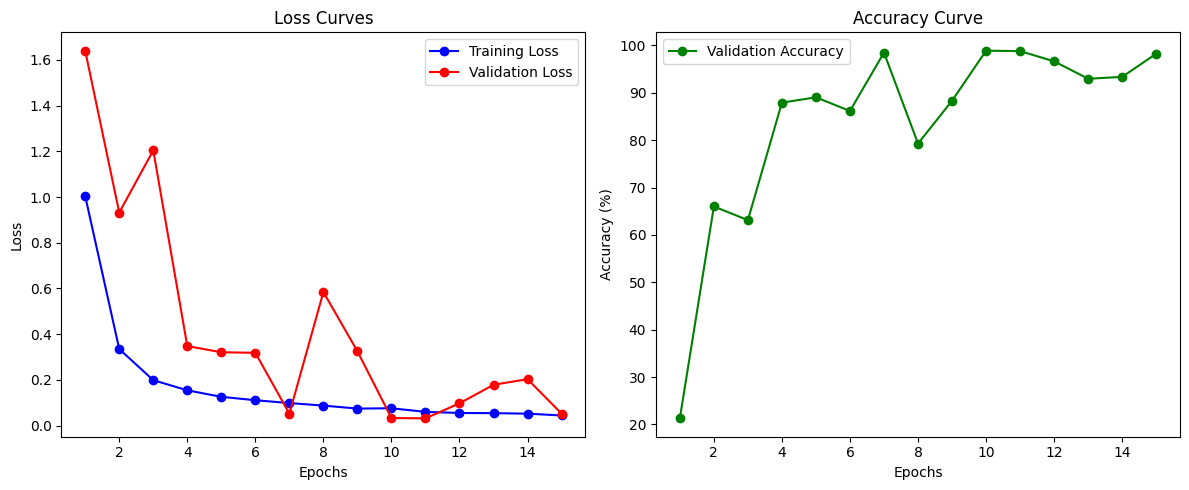

In [19]:
# Plotting accuracy and loss curves
def plot_curves(train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 5))

    # Plot Loss Curves
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy Curves
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, 'go-', label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the curves
plot_curves(train_losses, val_losses, val_accuracies)